# 2-2-1 Protocol

This notebook study the performance of 2-2-1 protocol, which means doing 2-1 entanglement distillation twice and do a 2-1 classical advantage distillation.

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

# Global variable for the number of pairs
num_pairs = 2

def base(M, n):
    # calculate the image of the base under a matrix M
    # M: Binary matrix
    # n: number of pairs

    # make a set of all combinations of the first column and the last n columns (these correspond to X_1, Z_1,...,Z_n)
    s = []
    for i in range(n+1, 2*n):
        s.append(M[0:2*n, i])
    powerset = it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1))
    
    res = [vector(GF(2),2*n)]
        
    for i in powerset:
        v = vector(sum(i))     # calculate the sum of the elements of each combination (e.g IZZ = IZI + IIZ)
        res.append(v)
        
    return res


def pillars(M, n):
    # calculate the image of the pillars under a matrix M
    # M: Binary matrix
    # n: number of pairs
    X1 = vector(M[0:2*n, 0])
    Z1 = vector(M[0:2*n, n])
    Y1 = X1 + Z1
    
    pI = base(M, n)
    pX = [(X1 + b) for b in pI]
    pY = [(Y1 + b) for b in pI]
    pZ = [(Z1 + b) for b in pI]
    
    return [pI, pX, pY, pZ]   


def generate_pauli_dict(p_I, p_X, p_Y, p_Z):

    # Given a Pauli vector return a dictionary in {"XX": p_X*p_X, ...}. This is a representation of a state \psi \otimes \psi.

    paulis = ["I", "X", "Y", "Z"]
    result = {}
    for p1 in paulis:
        for p2 in paulis:
            value = 1
            if p1 == "I":
                value *= p_I
            if p1 == "X":
                value *= p_X
            if p1 == "Y":
                value *= p_Y
            if p1 == "Z":
                value *= p_Z
            if p2 == "I":
                value *= p_I
            if p2 == "X":
                value *= p_X
            if p2 == "Y":
                value *= p_Y
            if p2 == "Z":
                value *= p_Z
            result[p1+p2] = value      
    return result  


def bin_to_pauli(input):
    # Convert a binary string to correspond Pauli operator, also in string.
    if input == "00":
        return "I"
    elif input == "10":
        return "X"
    elif input == "01":
        return "Z"
    elif input == "11":
        return "Y"
    
def translate_pauli(pillars):
    # Given pillars, get the Pauli elements in string format.
    # For example, if DEJMPS matrix is given, this returns [["II", "YY"], ["XX", "ZZ"], ["ZX", "XZ"], ["YI", "IY"]]
    pilI = []
    pilX = []
    pilY = []
    pilZ = []

    #Case: pilI
    pilI.append(bin_to_pauli(str(pillars[0][0][0]) + str(pillars[0][0][2])) + bin_to_pauli(str(pillars[0][0][1]) + str(pillars[0][0][3]))) 
    pilI.append(bin_to_pauli(str(pillars[0][1][0]) + str(pillars[0][1][2])) + bin_to_pauli(str(pillars[0][1][1]) + str(pillars[0][1][3]))) 

    #Case: pilX
    
    pilX.append(bin_to_pauli(str(pillars[1][0][0]) + str(pillars[1][0][2])) + bin_to_pauli(str(pillars[1][0][1]) + str(pillars[1][0][3]))) 
    pilX.append(bin_to_pauli(str(pillars[1][1][0]) + str(pillars[1][1][2])) + bin_to_pauli(str(pillars[1][1][1]) + str(pillars[1][1][3]))) 

    #Case: pilY
    pilY.append(bin_to_pauli(str(pillars[2][0][0]) + str(pillars[2][0][2])) + bin_to_pauli(str(pillars[2][0][1]) + str(pillars[2][0][3]))) 
    pilY.append(bin_to_pauli(str(pillars[2][1][0]) + str(pillars[2][1][2])) + bin_to_pauli(str(pillars[2][1][1]) + str(pillars[2][1][3]))) 

    #Case: pilZ
    pilZ.append(bin_to_pauli(str(pillars[3][0][0]) + str(pillars[3][0][2])) + bin_to_pauli(str(pillars[3][0][1]) + str(pillars[3][0][3]))) 
    pilZ.append(bin_to_pauli(str(pillars[3][1][0]) + str(pillars[3][1][2])) + bin_to_pauli(str(pillars[3][1][1]) + str(pillars[3][1][3]))) 
    
    return [pilI, pilX, pilY, pilZ]


def sum_up_dict(pauli_dict, lst_pauli_str):
    # Given a Pauli dictionary {"XX": ..., "XY": ..., ...} and a list of Pauli string ["XX": ,"YY", ...]
    # return the sum of corresponding values.
    result = 0
    for p in lst_pauli_str:
        result += pauli_dict[p]
    return result

def get_components(input_vector, M):
    # Given an input Pauli vector, and a clifford operator. Get Pauli vector after distillation circuit M.
    pauli_dict = generate_pauli_dict(input_vector[0], input_vector[1], input_vector[2], input_vector[3])
    pil_str = translate_pauli(pillars(M,2)) 
    p_I = sum_up_dict(pauli_dict, pil_str[0]) / sum_up_dict(pauli_dict, list(it.chain.from_iterable(pil_str))) 
    p_X = sum_up_dict(pauli_dict, pil_str[1]) / sum_up_dict(pauli_dict, list(it.chain.from_iterable(pil_str))) 
    p_Y = sum_up_dict(pauli_dict, pil_str[2]) / sum_up_dict(pauli_dict, list(it.chain.from_iterable(pil_str))) 
    p_Z = sum_up_dict(pauli_dict, pil_str[3]) / sum_up_dict(pauli_dict, list(it.chain.from_iterable(pil_str))) 

    return [p_I, p_X, p_Y, p_Z]

def get_werner(fidelity):
    # Generate Werner state in Pauli vector form.
    return [fidelity, (1-fidelity) / 3, (1-fidelity) / 3, (1-fidelity) / 3]

def get_keyrate(p_vector):
    # Get hashing bound key rate given a Pauli vector.
    H = -1 * (p_vector[0] * np.log2(p_vector[0]) + p_vector[1] * np.log2(p_vector[1]) + p_vector[2] * np.log2(p_vector[2]) + p_vector[3] * np.log2(p_vector[3])) 

    return 1 - H

# Sanity check - DEJMPS 

In [3]:
# Input fidelity list to be scanned
fid_list = np.linspace(0.5, 1)

#DEJMPS ONLY
ed_only_fidelity = []
ed_only_keyrate = []
nothing_keyrate = []

In [4]:
for f in fid_list:
    werner = get_werner(f)
    M = load(f'ED_transversal/2_pair/ED2_11.sobj').inverse()
    #pillars[0]: I, pillars[1]: X, pillars[2]: Y, pillars[3]: Z
    first_state = get_components(werner, M)
    ed_only_fidelity.append(first_state[0])
    ed_only_keyrate.append(get_keyrate(first_state))
    nothing_keyrate.append(get_keyrate(werner))


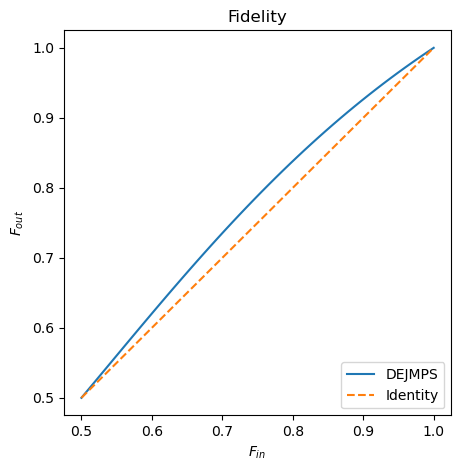

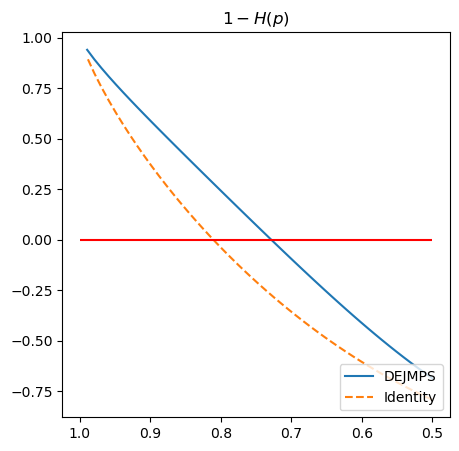

In [5]:
plt.figure(figsize=(5,5))
plt.plot(fid_list, ed_only_fidelity, label = "DEJMPS")
plt.plot(fid_list, fid_list, '--',label = "Identity")
plt.legend(loc="lower right")
plt.xlabel("$F_{in}$")
plt.ylabel("$F_{out}$")
plt.title("Fidelity")


plt.figure(figsize=(5,5))
plt.plot(fid_list, ed_only_keyrate, label= "DEJMPS")
plt.plot(fid_list,nothing_keyrate, '--', label= 'Identity')
plt.hlines(0,0.5,1, colors='red')
plt.legend(loc="lower right")
plt.title("$1-H(p)$")
plt.gca().invert_xaxis()

# ED+CAD

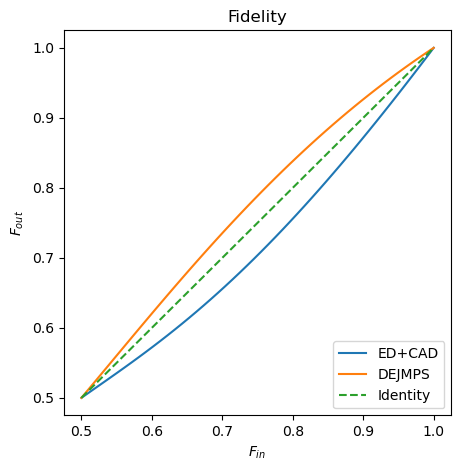

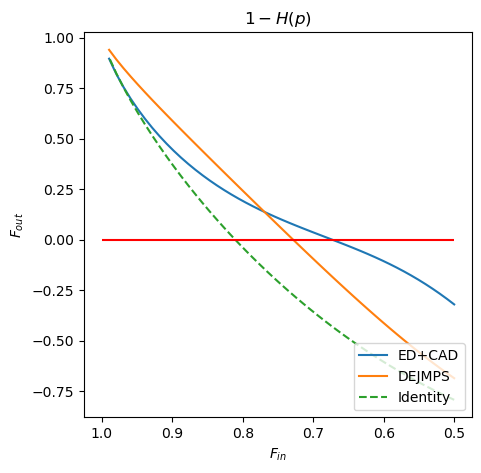

In [7]:
# ED:0  CNOT:0 is a good case.  (ED+CAD makes things better!)
# ED:10 CNOT:0 interesting      (ED+CAD makes things worse, in terms of fidelity)
# ED:0  CNOT:4 same             (ED+CAD = ED only)

# CNOT: 1 is the identiy

ed_cad_fidelity = []
ed_cad_rates = []
for f in fid_list:
    
    werner = get_werner(f)
    
    # NOTE THAT MY SOBJS ARE FORWARD OPERATOR NOT INVERSE!
    M = load(f'ED_transversal/2_pair/ED2_10.sobj').inverse()
    CNOT = load(f'CNOT_subgroup/2_pair/cnots_0.sobj').inverse()
    
    #pillars[0]: I, pillars[1]: X, pillars[2]: Y, pillars[3]: Z
    
    #------------------------------------------------------
    #                           ED
    #------------------------------------------------------
    first_state = get_components(werner, M)

    #------------------------------------------------------
    #                           CAD
    #------------------------------------------------------

    second_state = get_components(first_state, CNOT)
    ed_cad_fidelity.append(second_state[0])
    ed_cad_rates.append(get_keyrate(second_state))



plt.figure(figsize=(5,5))
plt.plot(fid_list, ed_cad_fidelity, label = "ED+CAD")
plt.plot(fid_list, ed_only_fidelity, label = "DEJMPS")
plt.plot(fid_list, fid_list, '--', label = "Identity")
plt.xlabel("$F_{in}$")
plt.ylabel("$F_{out}$")
plt.legend(loc="lower right")
plt.title("Fidelity")

plt.figure(figsize=(5,5))
plt.plot(fid_list, ed_cad_rates, label="ED+CAD")
plt.plot(fid_list, ed_only_keyrate, label="DEJMPS")
plt.plot(fid_list,nothing_keyrate, '--',label= 'Identity')
plt.hlines(0,0.5,1, colors='red')
plt.legend(loc="lower right")
plt.title("$1-H(p)$")
plt.xlabel("$F_{in}$")
plt.ylabel("$F_{out}$")
plt.gca().invert_xaxis()